In [1]:

from BondFlow.data.dataloader import get_dataloader
# from BondFlow.models.adapter import build_plm_encoder
from BondFlow.models.Loss import *
import torch
import os
import random
import numpy as np
from collections import defaultdict
import BondFlow.data.SM_utlis as smu


/home/fit/lulei/WORK/.conda/envs/apm_env/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, weight, bias=None):
/home/fit/lulei/WORK/.conda/envs/apm_env/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:70: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):


In [2]:
from BondFlow.data import utils as iu
import logging
import torch.nn as nn


import torch

import logging
from hydra.core.hydra_config import HydraConfig
import numpy as np
import random
import hydra
from hydra import initialize, compose
from BondFlow.models.sampler_test import *

from omegaconf import OmegaConf
import multiprocessing as mp
mp.set_start_method('spawn', force=True)


def make_deterministic(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


#conf.inference.ckpt_override_path= "../Train/weights_base3/best_model.pth"
config_file = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/base.yaml"
config_path = os.path.dirname(config_file)
config_path = os.path.relpath(config_path)
config_name = os.path.basename(config_file).split(".yaml")[0]

# 创建模型 + DDP包装 
with initialize(version_base=None, config_path=config_path):
    conf = compose(config_name=config_name)

#调用主函数
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

log = logging.getLogger(__name__)
if conf.inference.seed is not None:
    make_deterministic()

# Check for available GPU and print result of check
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(torch.cuda.current_device())
    log.info(f"Found GPU with device_name {device_name}. Will run RFdiffusion on {device_name}")
else:
    log.info("////////////////////////////////////////////////")
    log.info("///// NO GPU DETECTED! Falling back to CPU /////")
    log.info("////////////////////////////////////////////////")

# Initialize sampler and target/contig.
sampler = Sampler(conf,device=device)  # 使用传入的 device 参数


model_config_path: apm.yaml
model_config_path: apm.yaml
build model_config_path: /WORK/PUBLIC/lulei_work/xjt/Protein_design/BondFlow/BondFlow/config/apm.yaml
loading APMBackboneWrapper
loading APMBackboneWrapper
[APMBackboneWrapper] Loaded wrapper from /home/fit/lulei/WORK/xjt/Protein_design/BondFlow/Train/weight_apm_backbone_complex9/best_model.pth: loaded~1352/1352, missing=0, unexpected=0, strict=False


In [3]:
conf.model.model_config_path

'apm.yaml'

In [4]:
from BondFlow.models.interpolant import _uniform_so3 as interpolant_uniform_so3
from multiflow_data import utils as du
from multiflow_data.so3_utils import sample_uniform as so3_sample_uniform
def _center_xyz_with_chain_and_hotspots(
    xyz_target: torch.Tensor,
    res_mask: torch.Tensor,
    str_mask: torch.Tensor,
    chain_ids: torch.Tensor | None = None,
    hotspots: torch.Tensor | None = None,
) -> torch.Tensor:
    """
    根据链信息与 hotspot / 固定结构掩码对坐标进行中心化。

    规则：
        - 单链：有固定结构 (str_mask=False) 时，以其 CA 几何中心为原点；否则用整体 CA 中心。
        - 多链：若提供 hotspot，则以 hotspot CA 平均中心为原点；
                否则用固定结构部分的 CA 中心；
                若仍不存在，则退化为整体 CA 中心。
    """
    B, L, _, _ = xyz_target.shape
    device = xyz_target.device
    dtype = xyz_target.dtype

    # ---- 1) 判定每个样本是单链还是多链 (batch 张量操作) ----
    if chain_ids is None:
        single_flag = torch.ones(B, 1, dtype=torch.bool, device=device)
    else:
        valid = chain_ids > 0  # 忽略 0 这一类占位 id
        has_valid = valid.any(dim=1, keepdim=True)  # [B,1]

        # 为 masked min/max 构造大/小哨兵值
        big_pos = torch.iinfo(chain_ids.dtype).max
        big_neg = torch.iinfo(chain_ids.dtype).min
        chain_min = torch.where(
            valid, chain_ids, torch.full_like(chain_ids, big_pos)
        ).amin(dim=1, keepdim=True)
        chain_max = torch.where(
            valid, chain_ids, torch.full_like(chain_ids, big_neg)
        ).amax(dim=1, keepdim=True)

        multi_flag = has_valid & (chain_max != chain_min)
        single_flag = ~multi_flag  # [B,1]

    # ---- 2) 单链 / 多链下的中心掩码 (全张量实现) ----
    fixed_mask = (~str_mask.bool()) & res_mask.bool()  # [B,L]
    fixed_any = fixed_mask.any(dim=1, keepdim=True)  # [B,1]

    # 单链情形的中心掩码：优先固定结构，否则整体
    center_single = torch.where(fixed_any, fixed_mask, res_mask.bool())  # [B,L]

    # 多链情形：优先 hotspot，其次固定结构，否则整体
    if hotspots is not None:
        if hotspots.dtype == torch.bool:
            h_mask = hotspots & res_mask.bool()
        else:
            h_mask = (hotspots > 0) & res_mask.bool()
        h_any = h_mask.any(dim=1, keepdim=True)  # [B,1]
        center_multi = torch.where(h_any, h_mask, center_single)  # [B,L]
    else:
        center_multi = center_single

    # 根据 single_flag 在单链 / 多链规则之间选择
    center_mask = torch.where(single_flag, center_single, center_multi)  # [B,L]

    # 极端情况：某个样本 center_mask 全 False，则退化为“全部残基”
    valid_any = center_mask.any(dim=1, keepdim=True)  # [B,1]
    center_mask = torch.where(
        valid_any, center_mask, torch.ones_like(center_mask)
    )  # [B,L]

    # ---- 3) 基于 center_mask 计算几何中心并平移 ----
    ca_coords = xyz_target[:, :, 1, :]  # [B, L, 3]
    mask_f = center_mask.unsqueeze(-1).to(dtype)  # [B, L, 1]
    denom = mask_f.sum(dim=1, keepdim=True) + 1e-8  # [B, 1, 1]
    center = (ca_coords * mask_f).sum(dim=1, keepdim=True) / denom  # [B, 1, 3]

    # 扩展到原始维度 [B, 1, 1, 3] 以便从所有原子坐标中减去
    xyz_centered = xyz_target - center.unsqueeze(2)

    return xyz_centered
    
def sample_with_interpolant(
    xyz_target,
    res_mask,
    str_mask,
    hotspots,
    t,
    head_mask=None,
    tail_mask=None,
    N_C_anchor=None,
    chain_ids=None,
    
):
    """
    使用 Interpolant 对输入进行加噪或采样。

    Args:
        xyz_target (Tensor): (B, L, 3, 3) 目标坐标 (N, CA, C)。
        seq_target (Tensor): (B, L) 目标序列。
        ss_target (Tensor): (B, L, L) 目标二级结构。
        res_mask (Tensor): (B, L) 氨基酸残基掩码。
        str_mask (Tensor): (B, L) 结构掩码 (True=可扰动, False=固定结构)。
        seq_mask (Tensor): (B, L) 序列掩码。
        bond_diffuse_mask (Tensor): (B, L, L) 二级结构扩散掩码。
        pdb_idx (list): (为了兼容保留, 不再用于识别链)。
        t (Tensor): (B,) 扩散时间步。
        chain_ids (Tensor, optional): (B, L) full_chain_ids, 用于区分单链/多链。
        hotspots (Tensor, optional): (B, L) hotspot 掩码 (>0 视为 True)。

    Returns:
        dict: 包含加噪/采样后数据的字典。
    """
    # 1. 中心化 + 随机旋转 & 平移扰动
    #
    #   - 单链: 若存在固定结构 (str_mask=False), 以其 CA 几何中心为原点; 否则用整体几何中心。
    #   - 多链: 若提供 hotspot, 以 hotspot CA 平均中心为原点; 否则用固定结构部分的 CA 中心;
    #           若均不存在则退化为整体几何中心。
    xyz_centered = _center_xyz_with_chain_and_hotspots(
        xyz_target, res_mask, str_mask, chain_ids=chain_ids, hotspots=hotspots
    )
    B = xyz_centered.shape[0]
    device = xyz_centered.device
    dtype = xyz_centered.dtype

    # 随机旋转 (batch-wise)
    R = so3_sample_uniform(B).to(device=device, dtype=dtype)  # [B, 3, 3]

    xyz_rot = torch.einsum("bij,blkj->blki", R, xyz_centered)

    # 各向同性平移扰动
    epsilon = torch.randn(B, 1, 1, 3, device=device, dtype=dtype) * 1.5
    xyz_centered = xyz_rot + epsilon
    # 2. 从坐标计算旋转矩阵
    #rotmats = iu.get_R_from_xyz(xyz_centered)

    # 3. 调用 interpolant.corrupt_batch
    # noised_batch = self.interpolant.corrupt_batch(
    #     trans_1=xyz_centered[:, :, 1, :],
    #     rotmats_1=rotmats,
    #     aatypes_1=seq_target,
    #     ss_1=ss_target,
    #     res_mask=res_mask,
    #     trans_diffuse_mask=str_mask.float(),
    #     rots_diffuse_mask=str_mask.float(),
    #     aatypes_diffuse_mask=seq_mask.float(),
    #     ss_diffuse_mask=bond_diffuse_mask.float(),
    #     t=t
    # )

    #xyz_noised = iu.get_xyz_from_RT(noised_batch['rotmats_t'],noised_batch['trans_t'])
    
    # # 将head_mask和tail_mask位置的张量分别复制为锚定Body残基的特征
    # if (head_mask is not None or tail_mask is not None) and (N_C_anchor is not None):
    #     noised_batch['aatypes_t'] = iu.update_nc_node_features(noised_batch['aatypes_t'], N_C_anchor, head_mask, tail_mask)
    #     # 使用带offset的坐标更新函数
    #     xyz_noised = iu.update_nc_node_coordinates(xyz_noised, N_C_anchor, head_mask, tail_mask)
    #     xyz_centered = iu.update_nc_node_coordinates(xyz_centered, N_C_anchor, head_mask, tail_mask)
    
    return xyz_centered

In [5]:
batch_size = 1
pdb_list_path = "/home/fit/lulei/WORK/xjt/Protein_design/CyclicPeptide/Dataset/ALL_MMCIF/train_data5/LINKAF_tmp/cluster.tsv"
pdb_dir = "/home/fit/lulei/WORK/xjt/Protein_design/CyclicPeptide/Dataset/ALL_MMCIF/train_data5/LINKAF_CIF"

pdb_term_list_path="/home/fit/lulei/WORK/xjt/Protein_design/CyclicPeptide/Dataset/ALL_MMCIF/train_data5/LINK_TERM_MONO_tmp/cluster.tsv"
pdb_term_dir="/home/fit/lulei/WORK/xjt/Protein_design/CyclicPeptide/Dataset/ALL_MMCIF/train_data5/LINK_TERM_MONO_CIF"

pdb_com_list_path = "/home/fit/lulei/WORK/xjt/Protein_design/CyclicPeptide/Dataset/ALL_MMCIF/train_data5/COMPLEX_tmp/cluster.tsv"
pdb_com_dir = "/home/fit/lulei/WORK/xjt/Protein_design/CyclicPeptide/Dataset/ALL_MMCIF/train_data5/COMPLEX_CIF"


pdb_list_paths = [pdb_list_path,pdb_term_list_path,pdb_com_list_path]
pdb_dirs = [pdb_dir,pdb_term_dir,pdb_com_dir]

# plm_encoder = build_plm_encoder(sampler.model._folding_model,sampler.model._plm_type, device='cuda:0')

cache_dir = "/home/fit/lulei/WORK/xjt/Protein_design/CyclicPeptide/Dataset/ALL_MMCIF/data_cache/"
dataloader_train,dataloader_val = get_dataloader(conf, batch_size, pdb_list_path=pdb_list_paths, pdb_dir=pdb_dirs,
                                                    distributed=False, num_workers=0, 
                                                crop_length=256, device='cpu',rank=None, num_replicas=None,seed=44,
                                                val_split=0.025,sampling_ratios=[{'monomer': 1},{'monomer': 1},{'complex_space': 1}],
                                                dataset_probs=[0, 0.00,1],samples_num=None,
                                                cache_dir = cache_dir,        
                                                nc_pos_prob=0.3, hotspot_prob=1,)
                                                # plm_encoder = plm_encoder,
                                                # plm_max_chain_length=1024,)



print(len(dataloader_train),len(dataloader_val))

Training set: 92706 clusters (combined).
self.num_replicas None
self.rank None
self.total_size 92706
Validation set: 2379 clusters (combined).
self.num_replicas None
self.rank None
self.total_size 2379
92706 2379


In [6]:
print(len(dataloader_train),len(dataloader_val))

92706 2379


In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params = count_parameters(sampler.model)
print(f"模型的参数总量: {params}")

模型的参数总量: 57492786


In [8]:
import numpy as np
import matplotlib.pyplot as plt
def plot_tensor_heatmap(tensor, title="Tensor Heatmap", cmap="viridis"):
    """
    绘制L×L tensor矩阵的热图
    
    参数:
    tensor -- 输入的L×L矩阵
    title -- 热图标题(可选)
    cmap -- 颜色映射(可选)
    """
    plt.figure(figsize=(8, 6))
    
    # 显示热图
    im = plt.imshow(tensor, cmap=cmap)
    
    # 添加颜色条
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    # 设置标题和坐标轴
    plt.title(title)
    plt.xlabel("Column Index")
    plt.ylabel("Row Index")
    
    # 显示网格线(可选)
    plt.grid(False)
    
    plt.show()



In [9]:
batch_data = None
dataloader_train.sampler.set_epoch(1)
for i, batch in enumerate(dataloader_train):
    batch_data = batch
    break


(1, 6)
contig [['A/71-A/106:seq_PNA:str_PNA', 'A/107-A/139:seq_FIX:str_FIX', 'A/140-A/160:seq_PNA:str_PNA'], ['B/1-B/141:seq_FIX:str_FIX', 'New_21-21']]
hotspots ['B/139', 'B/138', 'B/140', 'B/136', 'B/135', 'B/85']


In [10]:
print(batch_data['pdb_id'])

['A0A660RM03_D3__A0A660RM03_D2_A__A0A660RM03_D3__A0A660RM03_D2_B_A']


In [11]:
xyz_target = batch_data['full_xyz']
rf_idx = batch_data['full_rf_idx']
res_mask = batch_data['res_mask']
seq_target = batch_data['full_seq']
xyz_center = sample_with_interpolant(xyz_target,batch_data['res_mask'],batch_data['full_mask_str'],
                                        batch_data['full_hotspot'],0,
                                        chain_ids=batch_data['full_chain_ids'])
B,L=xyz_target.shape[:2]


xyz_nan = torch.full((B, L, 14, 3), float('nan'))
xyz_nan[:,:,:4,:] = xyz_center[:,:,:4,:]
xyz_nan[:,-1,:,:] = float('nan')
xyz_nan[:,0,:,:] = float('nan')
# RTframes,allatom_xyz_withCN = sampler.allatom(seq_pred,xyz_pred[:,-1,...],
#                             alpha_s,use_H=False,bond_mat=bond_matrix_sampled,
#                             link_csv_path="/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/link.csv",
#                             res_mask=res_mask)

# RTframes,allatom_xyz_true = sampler.allatom(seq_target,xyz_centered,
#                         alpha_target,use_H=False,bond_mat=bond_matrix_target,
#                         link_csv_path="/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/link.csv",
#                         res_mask=final_res_mask)


from rfdiff.util import writepdb
import numpy as np

# Get the first sample from the batch
atoms_to_save = xyz_nan[0].cpu()
seq_to_save = seq_target[0].cpu()
res_mask_to_save = res_mask[0].cpu().numpy()

# Filter atoms and sequence based on residue mask
chain_pdb_idx = [res[0] for res in batch_data['full_origin_pdb_idx'][0]]
L = atoms_to_save.shape[0]
res_indices = np.arange(L)[res_mask_to_save.astype(bool)]
filtered_atoms = atoms_to_save[res_indices]
filtered_seq = seq_to_save[res_indices]

# Prepare arguments for writepdb
outfile = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/tests/output.pdb"
res = filtered_seq
ch = ['A'] * len(filtered_seq) # Assuming a single chain 'A'
resi = res_indices + 1 # PDB residue indices are 1-based

# Write the PDB file
writepdb(outfile, filtered_atoms, res,chain_idx=chain_pdb_idx,idx_pdb=rf_idx[0])


# Get the first sample from the batch
print(xyz_target.shape)
xyz_target[:,-1,:,:] = float('nan')
xyz_target[:,0,:,:] = float('nan')
atoms_to_save = xyz_target[:,:,:4,:][0].cpu()

seq_to_save = seq_target[0].cpu()
res_mask_to_save = res_mask[0].cpu().numpy()

# Filter atoms and sequence based on residue mask
chain_pdb_idx = [res[0] for res in batch_data['full_origin_pdb_idx'][0]]
L = atoms_to_save.shape[0]
res_indices = np.arange(L)[res_mask_to_save.astype(bool)]
filtered_atoms = atoms_to_save[res_indices]
filtered_seq = seq_to_save[res_indices]

# Prepare arguments for writepdb
outfile = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/tests/output_orig.pdb"
res = filtered_seq
ch = ['A'] * len(filtered_seq) # Assuming a single chain 'A'
resi = res_indices + 1 # PDB residue indices are 1-based

# Write the PDB file
writepdb(outfile, filtered_atoms, res,chain_idx=chain_pdb_idx,idx_pdb=rf_idx[0])

torch.Size([1, 256, 14, 3])


In [12]:
batch_index = 0
print(batch_data['full_mask_str'][batch_index])
print(batch_data['full_mask_seq'][batch_index])
print(batch_data['res_mask'][batch_index])

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [13]:
print(batch_data.keys())
print(batch_data['full_pdb_idx'])
print(batch_data['full_origin_pdb_idx'])
print(batch_data['full_seq'].shape)
print(batch_data['pdb_id'])
print(batch_data['full_hotspot'].shape)
idx = torch.where(batch_data['full_hotspot']==1)
print(len(batch_data['full_origin_pdb_idx'][0]))
print(len(batch_data['full_pdb_idx'][0]))
print(idx)
b_idx, r_idx = idx

for b, r in zip(b_idx.tolist(), r_idx.tolist()):
    print(batch_data['full_origin_pdb_idx'][b][r])

dict_keys(['full_head_mask', 'full_tail_mask', 'full_seq', 'full_xyz', 'full_rf_idx', 'full_mask_str', 'full_mask_seq', 'full_pdb_idx', 'full_origin_pdb_idx', 'full_alpha', 'full_alpha_alt', 'full_alpha_tor_mask', 'full_chain_ids', 'res_mask', 'full_N_C_anchor', 'full_bond_matrix', 'full_bond_mask', 'full_hotspot', 'pdb_core_id', 'pdb_seq_full', 'pdb_idx_full', 'pdb_id', 'contig'])
[[('A', 1), ('A', 1), ('A', 2), ('A', 3), ('A', 4), ('A', 5), ('A', 6), ('A', 7), ('A', 8), ('A', 9), ('A', 10), ('A', 11), ('A', 12), ('A', 13), ('A', 14), ('A', 15), ('A', 16), ('A', 17), ('A', 18), ('A', 19), ('A', 20), ('A', 21), ('A', 22), ('A', 23), ('A', 24), ('A', 25), ('A', 26), ('A', 27), ('A', 28), ('A', 29), ('A', 30), ('A', 31), ('A', 32), ('A', 33), ('A', 34), ('A', 35), ('A', 36), ('A', 37), ('A', 38), ('A', 39), ('A', 40), ('A', 41), ('A', 42), ('A', 43), ('A', 44), ('A', 45), ('A', 46), ('A', 47), ('A', 48), ('A', 49), ('A', 50), ('A', 51), ('A', 52), ('A', 53), ('A', 54), ('A', 55), ('A', 5

In [14]:
batch_index = 0
print(batch_data['full_seq'][batch_index])
print(batch_data['full_head_mask'][batch_index])
print(batch_data['full_tail_mask'][batch_index])
print(batch_data['full_rf_idx'][batch_index])
N_index = 1#torch.where(batch_data['full_N_C_anchor'][0,:,:,0]==1)[0].max()
C_index =260 #`torch.where(batch_data['full_N_C_anchor'][0,:,:,1]==1)[0].min()
N_vuratal_index = 0#torch.where(batch_data['full_N_C_anchor'][0,:,:,0]==1)[0].min()
C_vuratal_index = 260#torch.where(batch_data['full_N_C_anchor'][0,:,:,1]==1)[0].max()
print(N_index,C_index)
print(torch.where(batch_data['full_N_C_anchor'][batch_index,:,:,1]==1))
print(torch.where(batch_data['full_N_C_anchor'][batch_index,:,:,0]==1))
print(f"N residue {N_index}",batch_data['full_xyz'][batch_index,N_index,:3,:])
print(f"C residue {C_index}",batch_data['full_xyz'][batch_index,C_index,:3,:])
print(f"N virtual residue {N_vuratal_index}",batch_data['full_xyz'][batch_index,N_vuratal_index,:3,:])
print(f"C virtual residue {C_vuratal_index}",batch_data['full_xyz'][batch_index,C_vuratal_index,:3,:])
print((((batch_data['full_xyz'][batch_index,C_vuratal_index,1,:]-batch_data['full_xyz'][batch_index,N_vuratal_index,1,:])**2).sum())**0.5)
print("bond matrix == 1 的索引对:",torch.where(batch_data['full_bond_matrix'][batch_index] * (1-torch.eye(batch_data['full_bond_matrix'][0].shape[1],dtype=torch.float32,device=batch_data['full_bond_matrix'][0].device))==1))



tensor([19, 19, 10,  3,  5,  0,  9, 11,  3,  6, 13, 19,  3,  7,  9,  4, 19,  9,
         0, 16,  9,  5,  0, 16, 16,  3,  9,  6,  2,  9,  0,  5, 10,  9,  9, 15,
        11,  2, 11,  6, 16,  3, 11, 14,  9, 13,  7,  4, 13,  9,  7,  7, 11,  1,
         0, 11, 11,  7,  9,  6,  9, 10, 11, 11, 15,  7, 10, 15,  4, 13,  7,  3,
        14, 15, 19,  7,  9, 11,  0, 18, 15, 11, 10, 19, 18, 13, 15,  6,  9, 11,
        11, 11,  0,  0,  9,  6,  2,  2, 13,  7, 13, 15, 11, 13, 19, 15, 10,  7,
         2, 11,  0,  3, 10,  2,  6, 16,  3, 13, 10,  6, 18, 13,  0,  5,  3, 14,
         3, 16,  3,  9,  9, 10,  7, 18,  9,  6,  3,  9, 19,  3,  7, 11,  1, 13,
        10,  6, 19,  0, 16,  1, 19,  0, 11,  9, 11, 14,  9,  9, 10,  9, 11, 15,
         7, 15, 16,  6,  0,  7,  0,  1,  0,  0, 15, 15,  8, 16,  7,  0, 10,  0,
         7, 15,  3,  1,  0, 13, 16,  6,  0, 13, 11, 11, 16,  7,  9,  9,  1,  0,
        18,  7,  9,  5,  6, 10, 13,  6,  9,  0,  6,  9, 13, 11, 14, 14, 16,  7,
         1,  0,  0, 10, 13, 15,  5, 15, 

IndexError: index 260 is out of bounds for dimension 1 with size 256

(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))


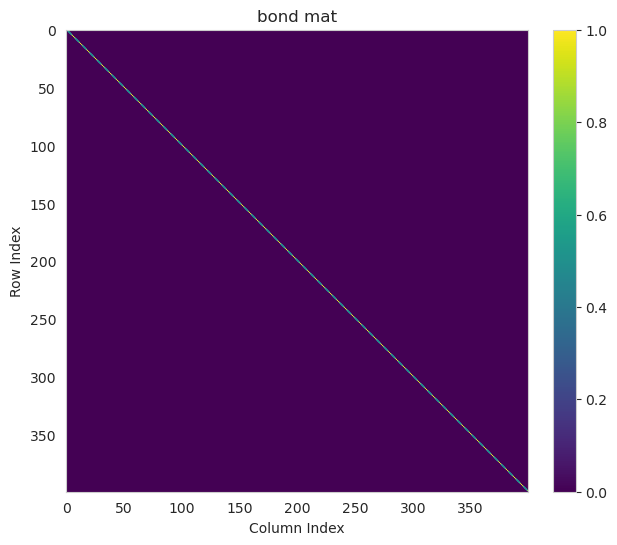

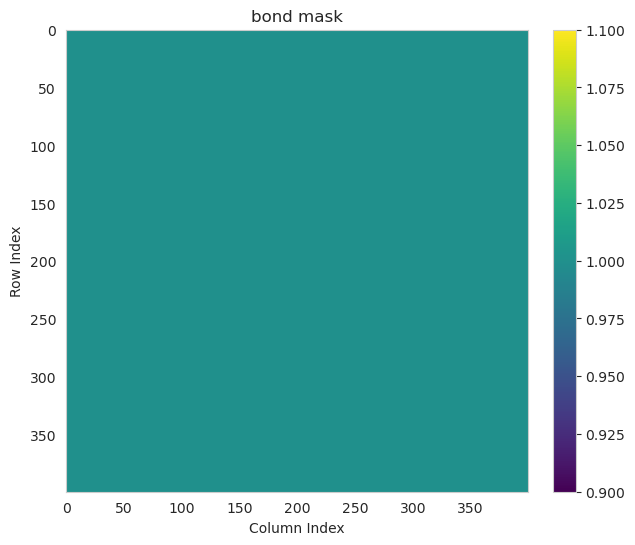

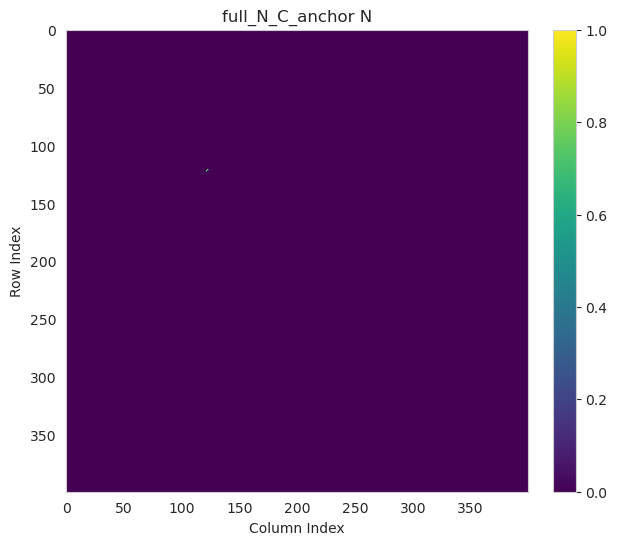

(tensor([  0,   1, 121, 122]), tensor([  1,   0, 122, 121]))


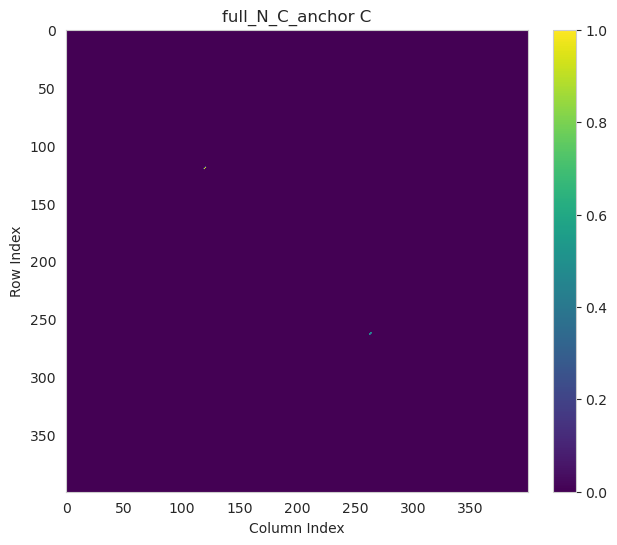

(tensor([119, 120, 262, 263]), tensor([120, 119, 263, 262]))
(tensor([120, 263]),)


In [ ]:
batch_idx =0
print(torch.where(batch_data['full_bond_matrix'][batch_idx] * (1-torch.eye(batch_data['full_bond_matrix'][0].shape[1],dtype=torch.float32,device=batch_data['full_bond_matrix'][0].device).unsqueeze(0))==1))
plot_tensor_heatmap(batch_data['full_bond_matrix'][batch_idx],"bond mat")
plot_tensor_heatmap(batch_data['full_bond_mask'][batch_idx], "bond mask")
plot_tensor_heatmap(batch_data['full_N_C_anchor'][batch_idx,:,:,0], "full_N_C_anchor N")
print(torch.where(batch_data['full_N_C_anchor'][batch_idx,:,:,0]==1))
plot_tensor_heatmap(batch_data['full_N_C_anchor'][batch_idx,:,:,1], "full_N_C_anchor C")
print(torch.where(batch_data['full_N_C_anchor'][batch_idx,:,:,1]==1))
print(torch.where(batch_data['full_tail_mask'][batch_idx,:]==1))


In [15]:

def log_nan_loss(loss_tensor, loss_name, pdb_id, log_file_path):
    """
    Logs a message if the loss is NaN.

    Args:
        loss_tensor (torch.Tensor): The loss value.
        loss_name (str): The name of the loss (e.g., 'frame', 'seq').
        batch_data (dict): The batch data dictionary, containing 'pdb_id'.
        log_file_path (str): The path to the log file.
    
    Returns:
        bool: True if the loss was NaN, False otherwise.
    """
    if torch.isnan(loss_tensor):
        with open(log_file_path, 'a') as f:
            pdb_ids = " ".join(pdb_id)
            log_message = f"{loss_name} nan {pdb_ids} {loss_tensor.item()}\\n"
            f.write(log_message)
            print(log_message)
        return True
    return False
log_file_path = "/home/fit/lulei/WORK/xjt/Protein_design/RFdiffusion/mytest/tests/train_log.txt"


def print_gpu_memory(loss_name):
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        print(f'GPU Memory after {loss_name}: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

partial_T_threshold = 0.25
# Ratio of samples to draw from (partial_T_threshold, 1 - eps_t)
partial_T_high_ratio = 0.75

def sample_partial_t(
    batch_size: int,
    device: torch.device,
    same_T_in_batch: bool,
    partial_T_threshold: float,
    eps_t: float,
    partial_T_high_ratio: float,
):
    """Sample diffusion time t (partial_T) using a two-interval mixed uniform distribution.

    - With probability partial_T_high_ratio, sample uniformly from [partial_T_threshold, 1 - eps_t]
    - Otherwise sample uniformly from [0, partial_T_threshold]
    - If same_T_in_batch is True, all samples in the batch use the same t
    """
    high_range = (1 - eps_t) - partial_T_threshold
    low_range = partial_T_threshold
    if same_T_in_batch:
        if high_range <= 0:
            t_single = torch.rand((1,), device=device) * max(low_range, 0.0)
        elif low_range <= 0:
            t_single = partial_T_threshold + torch.rand((1,), device=device) * max(high_range, 0.0)
        else:
            u = torch.rand((1,), device=device)
            high_sample = partial_T_threshold + torch.rand((1,), device=device) * high_range
            low_sample = torch.rand((1,), device=device) * low_range
            t_single = torch.where(u < partial_T_high_ratio, high_sample, low_sample)
        partial_T = t_single.repeat(batch_size)
    else:
        if high_range <= 0:
            partial_T = torch.rand((batch_size,), device=device) * max(low_range, 0.0)
        elif low_range <= 0:
            partial_T = partial_T_threshold + torch.rand((batch_size,), device=device) * max(high_range, 0.0)
        else:
            u = torch.rand((batch_size,), device=device)
            high_sample = partial_T_threshold + torch.rand((batch_size,), device=device) * high_range
            low_sample = torch.rand((batch_size,), device=device) * low_range
            partial_T = torch.where(u < partial_T_high_ratio, high_sample, low_sample)
    print(f"partial_T: {partial_T}")
    return partial_T

def compute_importance_weight(
    partial_T: torch.Tensor,
    partial_T_threshold: float,
    eps_t: float,
    partial_T_high_ratio: float,
):
    """Compute importance-sampling weight that debiases the mixed t sampling to target Uniform[0, 1-eps_t]."""
    high_range = (1 - eps_t) - partial_T_threshold
    low_range = partial_T_threshold
    p_true = 1.0 / max(1.0 - eps_t, 1e-8)
    low_mask = (partial_T < partial_T_threshold).float()
    high_mask = 1.0 - low_mask
    low_den = max(low_range, 1e-8)
    high_den = max(high_range, 1e-8)
    p_sample = low_mask * ((1.0 - partial_T_high_ratio) / low_den) + high_mask * (partial_T_high_ratio / high_den)
    return (p_true / p_sample).detach()

def compute_w_nld(
    partial_T: torch.Tensor,
    partial_T_threshold: float,
    eps_t: float,
):
    """Compute normalized linear time weight w_nld with E[w_nld]=1 under Uniform[0, 1-eps_t]."""
    t0 = partial_T_threshold
    t1 = 1.0 - eps_t
    den = max(t1 - t0, 1e-8)
    t1_den = max(t1, 1e-8)
    w_raw = torch.clamp((partial_T - t0) / den, min=0.0, max=1.0)
    ew = (t1 - t0) / (2.0 * t1_den)
    return w_raw / max(ew, 1e-8)

    
def model_forward(sampler,batch_data,criterion_frame, criterion_seq, 
                                                criterion_bond,
                                                criterion_FAPE,
                                                criterion_torsion,
                                                criterion_bond_coh,
                                                eps_t = 5e-3,
                                                criterion_clash=None):
    
    # 1. Extract data from batch and move to device
    xyz_orig = batch_data['full_xyz'].to(sampler.device) # (B, L, 14, 3)
    seq_target = batch_data['full_seq'].to(sampler.device)
    bond_matrix_target = batch_data['full_bond_matrix'].to(sampler.device)
    res_mask = batch_data['res_mask'].to(sampler.device)
    str_mask = batch_data['full_mask_str'].to(sampler.device)
    seq_mask = batch_data['full_mask_seq'].to(sampler.device)
    bond_mask = batch_data['full_bond_mask'].to(sampler.device)
    head_mask = batch_data['full_head_mask'].to(sampler.device)
    tail_mask = batch_data['full_tail_mask'].to(sampler.device)
    pdb_idx = batch_data['full_pdb_idx']
    chain_ids = batch_data['full_chain_ids'].to(sampler.device)
    rf_idx = batch_data['full_rf_idx'].to(sampler.device)
    alpha_target = batch_data['full_alpha'].to(sampler.device)
    alpha_alt_target = batch_data['full_alpha_alt'].to(sampler.device)  # [L,10,2] for alpha torsions, [L,10,2] for alpha torsion alt
    alpha_tor_mask = batch_data['full_alpha_tor_mask'].to(sampler.device)
    pdb_id = batch_data['pdb_id']
    N_C_anchor = batch_data['full_N_C_anchor'].to(sampler.device)
    final_res_mask = res_mask.float() * (1 - head_mask.float()) * (1 - tail_mask.float())
        # 新增：原始 PDB 信息（由 dataloader 提供，用于整链 PLM）
    origin_pdb_idx = batch_data['full_origin_pdb_idx']  # list[list[(chain,res)]]
    pdb_seq_full = batch_data['pdb_seq_full']           # list[np.ndarray 或 1D tensor]
    pdb_idx_full = batch_data['pdb_idx_full']           # list[list[(chain,res)]]
    pdb_core_id = batch_data['pdb_core_id']             # list[str]
    hotspots = batch_data['full_hotspot'].to(sampler.device)

    print_gpu_memory('data to device')

    
    # Create dummy tensors for ss since it's not in batch_data
    B, L = seq_target.shape

    # 2. Get random timestep
        # 2. Get random timestep (mixture sampling) and compute weights
    partial_T = sample_partial_t(
        batch_size=B,
        device=sampler.device,
        same_T_in_batch=True,
        partial_T_threshold=partial_T_threshold,
        eps_t=eps_t,
        partial_T_high_ratio=partial_T_high_ratio,
    )

    # Importance Sampling weight for biased t sampling
    is_weight = compute_importance_weight(
        partial_T=partial_T,
        partial_T_threshold=partial_T_threshold,
        eps_t=eps_t,
        partial_T_high_ratio=partial_T_high_ratio,
    )

    # Normalized Linear Increasing time weight (w_nld)
    w_nld = compute_w_nld(
        partial_T=partial_T,
        partial_T_threshold=partial_T_threshold,
        eps_t=eps_t,
    )

    print("partial_T",partial_T)
    # 3. Noise the data using interpolant's sample method
    xyz_noised, seq_noised, bond_noised,xyz_centered,rotmats =  sampler.sample_with_interpolant(xyz_orig[:,:,:3,:], 
                                                                            seq_target, 
                                                                            bond_matrix_target, 
                                                                            res_mask, 
                                                                            str_mask, 
                                                                            seq_mask,
                                                                            bond_mask, 
                                                                            hotspots, 
                                                                            partial_T,
                                                                            chain_ids,
                                                                            head_mask=head_mask,
                                                                            tail_mask=tail_mask,
                                                                            N_C_anchor=N_C_anchor)
    print("xyz_noised 0",xyz_noised[0,0,...])
    print("xyz_noised 1",xyz_noised[0,1,...])

    print_gpu_memory('after sample_with_interpolant')

    # 4. Preprocess batch for the model

    # 4. Preprocess batch for the model
    # plot_tensor_heatmap(bond_noised[0].cpu(), title="Noised Bond Matrix")
    # print(bond_noised[0][(bond_noised[0]>0)& (bond_noised[0]<1)])
    # plot_tensor_heatmap(bond_noised[1].cpu(), title="Noised Bond Matrix")
    # plot_tensor_heatmap(bond_matrix_target[0].cpu(), title="Bond Matrix")
    # plot_tensor_heatmap(bond_matrix_target[1].cpu(), title="Bond Matrix")
    # print(bond_noised[1][(bond_noised[1]>0)& (bond_noised[1]<1)])
    # plot_tensor_heatmap(bond_mask[0].cpu(), title="Bond mask")
    # plot_tensor_heatmap(bond_mask[1].cpu(), title="Bond mask")
    
    print_gpu_memory('after _preprocess_batch')
    # plot_tensor_heatmap(res_dist_matrix[0].cpu(), title="CA")
    # plot_tensor_heatmap(res_dist_matrix[1].cpu(), title="CA Dist Matrix")
    # 5. Model forward pass
    start_time = time.time()
        
    logits_aa, xyz_pred, alpha_s, bond_matrix = sampler.model(
            seq_noised=seq_noised,
            xyz_noised=xyz_noised,
            bond_noised=bond_noised,
            rf_idx=rf_idx,
            pdb_idx=pdb_idx,
            alpha_target=alpha_target,
            alpha_tor_mask=alpha_tor_mask,
            partial_T=partial_T,
            str_mask=str_mask,
            seq_mask=seq_mask,
            N_C_anchor=N_C_anchor,
            head_mask=head_mask,
            tail_mask=tail_mask,
            bond_mask=bond_mask,
            res_mask=res_mask,
            use_checkpoint=False,
            trans_1=xyz_centered[:,:,1,:].to(xyz_noised.dtype),
            rotmats_1= rotmats.to(xyz_noised.dtype),
            aatypes_1=seq_target.long(),
            bond_mat_1=bond_matrix_target,
            chain_ids=chain_ids,
            origin_pdb_idx=origin_pdb_idx,
            pdb_seq_full=pdb_seq_full,
            pdb_idx_full=pdb_idx_full,
            pdb_core_id=pdb_core_id,
            hotspots=hotspots,
        )

    seq_pred = torch.argmax(logits_aa, dim=-1)

    seq_noised_mask = (seq_noised == du.MASK_TOKEN_INDEX)
    seq_res_mask = seq_mask.float() * res_mask.float() * seq_noised_mask.float()
    seq_pred = seq_pred * seq_res_mask.float() + (1 - seq_res_mask.float()) * seq_target.long()

    str_res_mask = str_mask.float() * res_mask.float() 
    times = xyz_pred.size(1)
    # Reshape str_res_mask to broadcast with xyz_pred: (B, L) -> (B, 1, L, 1, 1)
    str_res_mask_expanded = str_res_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)
    xyz_pred = xyz_pred * str_res_mask_expanded + ( 1 - str_res_mask_expanded) * xyz_centered.unsqueeze(1).expand(-1,times,-1,-1,-1)[...,:3,:]


    print("model forward time:", time.time() - start_time)
    print_gpu_memory('after model forward pass')
    
    # return logits_2d, logits_aa, logits_exp, xyz_pred, alpha_s, bond_matrix, lddt
    # 计算frame损失
    target_times =xyz_centered.unsqueeze(1).expand(-1,times,-1,-1,-1)[...,:3,:]
    noise_times = xyz_noised.unsqueeze(1).expand(-1,times,-1,-1,-1)[...,:3,:]
    # print("center of xyz_pred:",xyz_pred[...,1,:].mean(dim=(1,2)))
    # print("center of xyz_noised:",noise_times[...,1,:].mean(dim=(1,2)))
    # print("center of xyz_target:",target_times[...,1,:].mean(dim=(1,2)))
    loss_frame_start = time.time()
    loss_frame = criterion_frame(xyz_pred, target_times,noise_times, mask = str_res_mask.bool(),t=partial_T)
    log_nan_loss(loss_frame, 'frame', pdb_id, log_file_path)
    loss_frame_time = time.time() - loss_frame_start
    print(f"frame loss time: {loss_frame_time}")
    print_gpu_memory('after loss_frame')


    loss_FAPE_start = time.time()
    loss_FAPE = criterion_FAPE(xyz_pred[:,-1,...],xyz_centered,final_res_mask, str_mask)
    #loss_FAPE = criterion_FAPE(xyz_pred,target_times,res_mask, str_mask)
    log_nan_loss(loss_FAPE, 'FAPE', pdb_id, log_file_path)
    loss_FAPE_time = time.time() - loss_FAPE_start
    print(f"FAPE loss time: {loss_FAPE_time}")
    print_gpu_memory('after loss_FAPE')

    loss_seq_start = time.time()    
    # 计算序列损失        
   
    loss_seq = criterion_seq(logits_aa, seq_target, mask=seq_res_mask.bool())
    log_nan_loss(loss_seq, 'seq', pdb_id, log_file_path)
    loss_seq_time = time.time() - loss_seq_start
    print(f"seq loss time: {loss_seq_time}")
    print_gpu_memory('after loss_seq')

    #计算键合矩阵的loss
    mask_res_bond_2d = (res_mask.unsqueeze(2).float() * res_mask.unsqueeze(1).float() * bond_mask.float()).bool()
    loss_bond_start = time.time()
    loss_bond = criterion_bond(bond_matrix, bond_matrix_target, mask_res_bond_2d)
    loss_bond_time = time.time() - loss_bond_start
    print(f"bond loss time: {loss_bond_time}")
    print_gpu_memory('after loss_bond')
    # plot_tensor_heatmap(bond_matrix_target[0].detach().cpu(), title="Bond Matrix")
    # plot_tensor_heatmap(bond_matrix[0].detach().cpu(), title="Bond Matrix pred")

    # # 用assert检查 bond_matrix[0] 是否为双随机矩阵（行和列和均接近1）
    # # 只在 mask_2d 有效位置检测双随机性
    # bm = bond_matrix[0].detach().cpu()
    # mask = mask_2d[0].detach().cpu()
    # # 为避免全0行/列影响，限定检测在 mask 有效的位置
    # row_valid = mask.sum(dim=1) > 0
    # col_valid = mask.sum(dim=0) > 0
    # row_sums = bm.sum(dim=1)
    # col_sums = bm.sum(dim=0)
    # assert torch.allclose(row_sums[row_valid], torch.ones_like(row_sums[row_valid]), atol=1e-2), \
    #     f"Row sums not close to 1: min={row_sums[row_valid].min().item()}, max={row_sums[row_valid].max().item()}"
    # assert torch.allclose(col_sums[col_valid], torch.ones_like(col_sums[col_valid]), atol=1e-2), \
    #     f"Column sums not close to 1: min={col_sums[col_valid].min().item()}, max={col_sums[col_valid].max().item()}"
    # plot_tensor_heatmap(bond_noised[0].detach().cpu(), title="bond_noised")

    t_threshold = 0.25
    partial_T_mask = (partial_T > t_threshold)

    # 计算clash loss
    sapmle_bond_start = time.time()
    mask_res_2d = (res_mask.unsqueeze(2).float() * res_mask.unsqueeze(1).float()).bool()
    bond_matrix_sampled = smu.sample_permutation(bond_matrix, mask_res_2d)
    sample_bond_time = time.time() - sapmle_bond_start
    print(f"sample bond time: {sample_bond_time}")

    allatom_start = time.time()
 
    RTframes,allatom_xyz_withCN = sampler.allatom(seq_pred,xyz_pred[:,-1,...],
                                alpha_s,use_H=False,bond_mat=bond_matrix_sampled,
                                link_csv_path="/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/link.csv",
                                res_mask=final_res_mask,
                                head_mask = head_mask,
                                tail_mask = tail_mask,
                                N_C_anchor = N_C_anchor)

    RTframes,allatom_xyz_true = sampler.allatom(seq_target,xyz_centered,
                            alpha_target,use_H=False,bond_mat=bond_matrix_target,
                            link_csv_path="/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/link.csv",
                            res_mask=final_res_mask,
                            head_mask = head_mask,
                            tail_mask = tail_mask,
                            N_C_anchor = N_C_anchor)

    allatom_time = time.time() - allatom_start

    print_gpu_memory('after allatom')


    loss_clash_start = time.time()
    loss_clash = criterion_clash(N_C_anchor,allatom_xyz_withCN, seq_target, final_res_mask*partial_T_mask[:,None].float(),
                                )* w_nld.mean()
    log_nan_loss(loss_clash, 'clash', pdb_id, log_file_path)
    loss_clash_time = time.time() - loss_clash_start
    print(f"clash loss time: {loss_clash_time}")
    print_gpu_memory('after loss_clash')
    # 计算torsion loss
    loss_torsion_start = time.time()
    alpha_tor_res_mask = alpha_tor_mask.float() * final_res_mask[:,:,None].float()*partial_T_mask[:,None,None].float()
    loss_torsion = criterion_torsion(alpha_s, alpha_target, alpha_alt_target, alpha_tor_res_mask,bond_mat=bond_matrix)* w_nld.mean()
    log_nan_loss(loss_torsion, 'torsion', pdb_id, log_file_path)
    loss_torsion_time = time.time() - loss_torsion_start
    print(f"torsion loss time: {loss_torsion_time}")
    print_gpu_memory('after loss_torsion')
    loss_bond_coh_start = time.time()   
    loss_bond_coh = criterion_bond_coh(
        bond_matrix=bond_matrix,
        res_mask=res_mask*partial_T_mask[:,None].float(),
        #seq_logits=logits_aa,
        true_seq = seq_target,
        seq_labels = seq_target,
        mask_2d=None,
        all_atom_coords = allatom_xyz_withCN,
        aatype = seq_target,
        t = None,
        head_mask=head_mask,
        tail_mask=tail_mask,
        nc_anchor=N_C_anchor,
        # true_bond_matrix=bond_matrix_target.float(),
    )* w_nld.mean()
    
    log_nan_loss(loss_bond_coh, 'bond_coh', pdb_id, log_file_path)
    loss_bond_coh_time = time.time() - loss_bond_coh_start
    print(f"bond_coh loss time: {loss_bond_coh_time}")
    print_gpu_memory('after loss_bond_coh')
    print("model loss-forward time:", time.time() - start_time)



    from rfdiff.util import writepdb
    import numpy as np

    # Get the first sample from the batch
    atoms_to_save = allatom_xyz_withCN[0].cpu()
    seq_to_save = seq_target[0].cpu()
    res_mask_to_save = res_mask[0].cpu().numpy()

    # Filter atoms and sequence based on residue mask
    chain_pdb_idx = [res[0] for res in batch_data['full_origin_pdb_idx'][0]]
    L = atoms_to_save.shape[0]
    res_indices = np.arange(L)[res_mask_to_save.astype(bool)]
    filtered_atoms = atoms_to_save[res_indices]
    filtered_seq = seq_to_save[res_indices]

    # Prepare arguments for writepdb
    outfile = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/tests/output.pdb"
    res = filtered_seq
    ch = ['A'] * len(filtered_seq) # Assuming a single chain 'A'
    resi = res_indices + 1 # PDB residue indices are 1-based

    # Write the PDB file
    writepdb(outfile, filtered_atoms, res,chain_idx=chain_pdb_idx,idx_pdb=rf_idx[0])

    print(f"Saved PDB file to {outfile}")

    outfile = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/tests/output_orig.pdb"
    res = seq_target[0].cpu()
    atoms_to_save = allatom_xyz_true[0].cpu()
    res_indices = np.arange(L)[res_mask_to_save.astype(bool)]
    filtered_atoms = atoms_to_save[res_indices]
    filtered_seq = seq_to_save[res_indices]
    res = filtered_seq
    writepdb(outfile, filtered_atoms, res,chain_idx=chain_pdb_idx,idx_pdb=rf_idx[0])

    # plot_tensor_heatmap(bond_matrix_target[0].detach().cpu(), title="Bond Matrix")
    # plot_tensor_heatmap(bond_matrix[0].detach().cpu(), title="Bond Matrix pred")
    # plot_tensor_heatmap(bond_matrix_sampled[0].detach().cpu(), title="bond_matrix_sampled")


        # 输出bond_mat中元素1的索引对
    bond_indices = torch.nonzero(bond_matrix_target* (1- torch.eye(bond_matrix_target.shape[1],dtype=torch.float32,device=bond_matrix_target.device).unsqueeze(0)) == 1)
    print("bond_matrix == 1 的索引对:")
    for idx in bond_indices:
        # idx is tensor([batch_idx, i, j])
        batch_idx, i, j = idx.tolist()
        print(f"batch {batch_idx}: ({i}, {j})")

    return loss_frame, loss_seq, loss_bond, loss_clash,loss_FAPE, loss_torsion, loss_bond_coh,partial_T,  seq_pred, res_mask


In [ ]:

# from rfdiff.util import writepdb
# import numpy as np
# from rfdiff.util_module import ComputeAllAtomCoords
# allatom = ComputeAllAtomCoords()
# print(batch_data['full_alpha'].shape)
# print(batch_data['full_xyz'].shape)
# _,atoms_to_save = allatom(batch_data['full_seq'],
#                         batch_data['full_xyz'][:,:,:3,:],
#                         batch_data['full_alpha'],use_H=False)

# # Get the first sample from the batch
# # seq_pred,xyz_pred[:,-1,...],alpha_s,use_H=False
# # atoms_to_save = allatom_xyz[0].cpu()
# seq_to_save = batch_data['full_seq'][0].cpu()
# res_mask_to_save = batch_data['res_mask'][0].cpu().numpy()
# atoms_to_save = atoms_to_save[0].cpu()


# # Filter atoms and sequence based on residue mask
# L = seq_to_save.shape[0]
# res_indices = np.arange(L)[res_mask_to_save.astype(bool)]
# filtered_atoms = atoms_to_save[res_indices]
# filtered_seq = seq_to_save[res_indices]

# # Prepare arguments for writepdb
# outfile = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/tests/output2.pdb"
# res = filtered_seq
# ch = ['A'] * len(filtered_seq) # Assuming a single chain 'A'
# resi = res_indices + 1 # PDB residue indices are 1-based

# # Write the PDB file
# writepdb(outfile, filtered_atoms, res)

# print(f"Saved PDB file to {outfile}")

In [16]:
torch.set_printoptions(profile='full')
from torch.optim.lr_scheduler import CosineAnnealingLR,CosineAnnealingWarmRestarts
import torch.optim  as optim 
criterion_frame = LFrameLoss(w_trans=0.5, w_rot=1,gamma=1,d_clamp = 25)
criterion_seq = LseqLoss()
criterion_bond = DSMCrossEntropyLoss()
criterion_FAPE = FAPELoss(clamp_distance = 20)
criterion_clash = OpenFoldClashLoss(device=device,debug_print_pairs=True)
criterion_torsion = TorsionLossLegacy()
link_csv_path = "/home/fit/lulei/WORK/xjt/Protein_design/BondFlow/BondFlow/config/link.csv"
criterion_bond_coh = BondCoherenceLoss(link_csv_path=link_csv_path, device=device,t_geom_threshold=0.5)
model = sampler.model

def configure_optimizers(model, learning_rate, weight_decay):
    decay, no_decay = [], []

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if (
            param.ndim == 1 or
            name.endswith(".bias") or
            "layernorm" in name.lower()
        ):
            no_decay.append(param)
            print("no_decay",name)
        else:
            decay.append(param)
            print("decay",name)

    optimizer = torch.optim.AdamW(
        [
            {"params": decay, "weight_decay": weight_decay},
            {"params": no_decay, "weight_decay": 0.0},
        ],
        lr=learning_rate,
        betas=(0.9, 0.999),
    )
    return optimizer

optimizer = configure_optimizers(model, 1e-4, 1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=1000, eta_min=1e-5)
from torch.amp import autocast, GradScaler
use_amp = False
scaler = GradScaler("cuda",enabled=use_amp)


no_decay backbone.plm_s_combine
decay backbone.node_feature_net.aatype_embedding.weight
decay backbone.node_feature_net.linear.0.weight
no_decay backbone.node_feature_net.linear.0.bias
decay backbone.node_feature_net.linear.2.weight
no_decay backbone.node_feature_net.linear.2.bias
decay backbone.node_feature_net.linear.4.weight
no_decay backbone.node_feature_net.linear.4.bias
no_decay backbone.node_feature_net.linear.5.weight
no_decay backbone.node_feature_net.linear.5.bias
decay backbone.edge_feature_net.linear_s_p.weight
no_decay backbone.edge_feature_net.linear_s_p.bias
decay backbone.edge_feature_net.linear_relpos.weight
no_decay backbone.edge_feature_net.linear_relpos.bias
decay backbone.edge_feature_net.rel_chain_emb.weight
decay backbone.edge_feature_net.edge_embedder.0.weight
no_decay backbone.edge_feature_net.edge_embedder.0.bias
decay backbone.edge_feature_net.edge_embedder.2.weight
no_decay backbone.edge_feature_net.edge_embedder.2.bias
decay backbone.edge_feature_net.edge_e

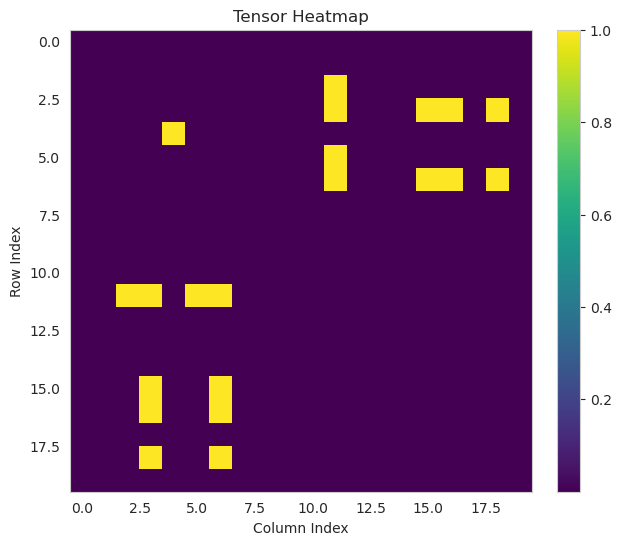

In [ ]:
plot_tensor_heatmap(criterion_bond_coh.compat_matrix.cpu())

In [17]:
def calculate_norm(loss, params_to_check,name):
    if loss.item() == 0:
        print(f"{name} loss is zero, skipping gradient calculation.")
        return 0.0
    fape_grads = torch.autograd.grad(loss, params_to_check, retain_graph=True, allow_unused=True)
    total_norm = 0.0
    for grad in fape_grads:
        if grad is not None:
            # 确保梯度不是空的 (如果allow_unused=True)
            total_norm += grad.data.norm(2).item() ** 2
    print( f"{name} grad:", total_norm ** 0.5)
    return total_norm ** 0.5


with torch.autograd.detect_anomaly():
    # for i in range(1000):
    import time 
    total_time = 0


    print("start "*10)
    for i, batch_data in enumerate(dataloader_train):
        print("start "*10)
        # if (i+1) // 64 != 115 or(i+1) // 64 != 116:
        #     continue
        #with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=use_amp):

        print(batch_data['pdb_id'])
        start_time = time.time()
        loss_frame, loss_seq, loss_bond, loss_clash, loss_FAPE, loss_torsion, loss_bond_coh,partial_T,  seq_pred, res_mask = model_forward(
                                                        sampler,
                                                        batch_data,
                                                        criterion_frame,
                                                        criterion_seq,
                                                        criterion_bond,
                                                        criterion_FAPE,
                                                        criterion_torsion,
                                                        criterion_bond_coh,
                                                        criterion_clash=criterion_clash
                                                        )

        print("loss frame",loss_frame.item())
        print("loss seq",loss_seq.item())
        print("loss bond",loss_bond.item())
        print("loss clash",loss_clash.item())
        print("loss FAPE",loss_FAPE.item())
        print("loss torsion",loss_torsion.item())
        print("loss bond_coh",loss_bond_coh.item())
        print("partial_T",partial_T)
        pdb_id = batch_data['pdb_id']
        #loss_total = loss_frame + loss_seq + loss_bond + loss_clash + loss_FAPE + loss_torsion

            # 为了效率，我们只检查最后一个共享层的参数
        # params_to_check = list(model.parameters())
        
        # loss_dict = {'frame':loss_frame, 'seq':loss_seq, 'bond':loss_bond, 'clash':loss_clash, 'FAPE':loss_FAPE, 'torsion':loss_torsion}
        # if params_to_check: # 确保参数列表不为空
        #     for name, loss in loss_dict.items():
        #         print(f"{name} loss:", loss.item())
        #         fape_grad_norm = calculate_norm(loss, params_to_check,name)

        loss_total =  0.75*loss_frame+ loss_seq +  loss_bond + 0.2*loss_clash +   0.25*loss_FAPE  + 0.5* loss_torsion + loss_bond_coh
        loss_total.backward()

        # for name, p in sampler.model.named_parameters():
        #     if p.requires_grad and p.grad is None:
        #         print("No grad:", name)

        # is_grad_nan_or_inf = torch.tensor([False])
        # for param in sampler.model.parameters():
        #     if param.grad is not None and (torch.isinf(param.grad).any() or torch.isnan(param.grad).any()):
        #         is_grad_nan_or_inf[0] = True
        #         print(f"Gradient is NaN or Inf for parameter: {param} at step {i} at pdb_id {pdb_id}")
        #         break # 发现一个就足够了，直接跳出循环
        #scaler.scale(loss_total).backward()


        # nn.utils.clip_grad_norm_(sampler.model.parameters(), 1)

        # total_norm = 0
        # for name, p in model.named_parameters():
        #     if p.grad is not None:
        #         param_norm = p.grad.data.norm(2)
        #         #if param_norm.item()>1:
        #         total_norm += param_norm.item() ** 2
        # total_norm = total_norm ** 0.5
        # print(f"Total gradient norm: {total_norm}")

        # max_norm = 5
        # torch.nn.utils.clip_grad_norm_(sampler.model.parameters(), max_norm=max_norm)
        # scaler.step(optimizer)
        # scaler.update()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        # if loss_bond.item() < 0.1:
        #     print("loss_bond is too small, break")
        #     print(i)
        #     break
        # if loss_bond_coh>10:
        print(aaaaaaaaaa)
        print("all time:", time.time() - start_time)



/tmp/ipykernel_22245/3261459297.py:15: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


start start start start start start start start start start 
(1, 6)
contig [['A/95-A/107:seq_PNA:str_PNA', 'A/108-A/114:seq_FIX:str_FIX', 'A/115-A/135:seq_PNA:str_PNA', 'A/136-A/141:seq_FIX:str_FIX', 'A/142-A/160:seq_PNA:str_PNA'], ['B/1-B/141:seq_FIX:str_FIX', 'New_45-45']]
hotspots ['B/139', 'B/138', 'B/140', 'B/136']
start start start start start start start start start start 
['A0A660RM03_D3__A0A660RM03_D2_A__A0A660RM03_D3__A0A660RM03_D2_B_A']
GPU Memory after data to device: 1486.97 MB
partial_T: tensor([0.3901], device='cuda:0')
partial_T tensor([0.3901], device='cuda:0')


Cache ./cache/cache_igso3_s0.100-1.500-1000_l1000_o1000-3.npz exists. Loading data from cache.
xyz_noised 0 tensor([[-0.4717, -3.1375, -4.2278],
        [-0.8449, -4.5448, -4.1522],
        [-2.0290, -4.7512, -3.2163]], device='cuda:0')
xyz_noised 1 tensor([[-0.8449, -4.5448, -4.1522],
        [-1.2181, -5.9522, -4.0765],
        [-2.4022, -6.1586, -3.1406]], device='cuda:0')
GPU Memory after after sample_with_interpolant: 1495.37 MB
GPU Memory after after _preprocess_batch: 1495.37 MB
model forward time: 4.161926031112671
GPU Memory after after model forward pass: 8364.64 MB
R loss: 1.2176
T loss: 23.6470
frame loss time: 0.344235897064209
GPU Memory after after loss_frame: 8364.73 MB
FAPE loss time: 0.26601147651672363
GPU Memory after after loss_FAPE: 8368.99 MB
seq loss time: 0.15009307861328125
GPU Memory after after loss_seq: 8369.00 MB
real offdiagonal gggggg :  tensor(0.2145, device='cuda:0', grad_fn=<DivBackward0>) denom:  tensor(2., device='cuda:0')
Debug - Real Off-Diag Pred

NameError: name 'aaaaaaaaaa' is not defined

In [ ]:
for i, batch in enumerate(dataloader_train):
    batch_data = batch
    break
#with torch.autograd.detect_anomaly():
loss_frame, loss_seq, loss_bond, loss_clash, loss_FAPE, loss_torsion, loss_bond_coh,partial_T,  seq_pred, res_mask = model_forward(sampler,batch_data,
                                                criterion_frame,
                                                criterion_seq,
                                                criterion_bond,
                                                criterion_FAPE,
                                                criterion_torsion,
                                                criterion_bond_coh,
                                                criterion_clash=criterion_clash
                                                )
print("loss frame",loss_frame)
print("loss seq",loss_seq)
print("loss bond",loss_bond)
print("loss clash",loss_clash)
print("loss FAPE",loss_FAPE)
print("loss torsion",loss_torsion)
print("loss bond_coh",loss_bond_coh)
print("partial_T",partial_T)
#loss_total = loss_frame + loss_seq + loss_bond + loss_clash + loss_FAPE + loss_torsion
loss_total =  loss_bond_coh #loss_frame+ loss_seq + loss_bond + loss_clash +  loss_torsion +loss_FAPE  + loss_bond_coh
loss_total.backward()


# 监控并打印梯度范数
total_norm = 0
for name, p in model.named_parameters():
    if p.grad is not None:
        param_norm = p.grad.data.norm(2)
        #if param_norm.item()>1:
        print(name,param_norm.item())
        total_norm += param_norm.item() ** 2
total_norm = total_norm ** 0.5
print(f"Total gradient norm: {total_norm}")

#更新梯度


optimizer.step()
optimizer.zero_grad()
